<b>Question 1:
Naive Bayes Spam Detector to classify Spam vs Not Spam
<br><br>
 </b>

In [8]:
# Read csv
import pandas as pd
message_csv=pd.read_csv('message.csv',sep=',', header=None, names=['Label','Message'])
message_csv.drop(message_csv.index[0], inplace=True)
print(message_csv.shape)
message_csv.head()

(5572, 2)


,Label,Message
1,0,go until jurong point crazy available only ...
2,0,ok lar joking wif u oni
3,1,free entry in 2 a wkly comp to win fa cup fina...
4,0,u dun say so early hor u c already then say
5,0,nah i don t think he goes to usf he lives aro...


In [9]:
print("Value counts of message_csv : ")
message_csv['Label'].value_counts(normalize=True)

Value counts of message_csv : 


0    0.865937
1    0.134063
Name: Label, dtype: float64

<b>80-20</b>

<b> message_csv is split into 80% training and 20% testing. <br><br>
Training set is cleaned into MxN set<br><br>
Probability terms are calculated on training set<br><br>
20% testing set is used to test and outcomes are collected<br><br>
Confusion matrix, Accuracy, Precision, Recall, Specificity are calculated
</b>

In [10]:
# entries in message_csc are shuffled
message_random=message_csv.sample(frac=1, random_state=1)

# Index of 80% for Training
training_index=round(len(message_random)*0.8)

#First 80% for Training
message_training = message_random[:training_index].reset_index(drop=True)

#Rest 20% for Testing
message_testing = message_random[training_index:].reset_index(drop=True)

In [11]:
print("Training: ")
print("Shape : ",message_training.shape)
print("Value counts of message_training : ")
message_training['Label'].value_counts(normalize=True)

Training: 
Shape :  (4458, 2)
Value counts of message_training : 


0    0.86541
1    0.13459
Name: Label, dtype: float64

In [12]:
print("Testing : ")
print("Shape : ",message_testing.shape)
print("Value counts of message_testing : ")
message_testing['Label'].value_counts(normalize=True)

Testing : 
Shape :  (1114, 2)
Value counts of message_testing : 


0    0.868043
1    0.131957
Name: Label, dtype: float64

<b>Cleaning the training set</b>

In [13]:
#to generate list of unique words
def generate_unique_words(training_set):
    training_set['Message']=training_set['Message'].str.split()
    unique_words=[]
    for message in training_set['Message']:
        for word in message:
            if word not in unique_words:
                unique_words.append(word)
    return unique_words

unique_words=generate_unique_words(message_training)
print("No of unique words : ",len(unique_words))

No of unique words :  7783


In [14]:
#returns dataframe with label, message and count of unique words in each message
def clean_training_set(training_set, unique_words):
    
    #Initiliasing dictionary of keys as unique words, each key has len(message_training) times [0].
    count_of_words_per_message={uniqueWord: [0]*len(training_set['Message'])for uniqueWord in unique_words}

    #Parse through each message, with each word, update the count of unique words in the dictionary 
    for index,message in enumerate(training_set['Message']):
        for word in message:
            count_of_words_per_message[word][index]+=1

    #Converting the dictionary to data frame        
    count_of_words_dataframe=pd.DataFrame(count_of_words_per_message)
    #count_of_words_dataframe.head()
    
    final_training_set=pd.concat([training_set, count_of_words_dataframe],axis=1)
    return final_training_set

In [15]:
final_training_set=clean_training_set(message_training,unique_words)
final_training_set.head()

,Label,Message,yep,by,the,pretty,sculpture,yes,princess,are,...,beauty,hides,secrets,n8,jewelry,related,trade,arul,bx526,wherre
0,0,"[yep, by, the, pretty, sculpture]",1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


given a message, we need to classify spam(1) or notspam(0)
for this we need to find the probability of it being Spam given the words the message contains
ie:
    P(Spam(1)|word_1,word_2,...word_n)
    
To compute this, we need probabilty of getting a spam, and product of probability of each word given a message is spam

    P(Spam(1)|word1,word2,...wordn)=P(Spam(1))*product of(P(word_i|Spam(1))) for all words in message

similarly for notSpam:
    
    P(notSpam(0)|word1,word2,...wordn)=P(notSpam(0))*product of(P(word_i|notSpam(0)))for all words in message
    
P(word_i|Spam(1)) and P(word_i|notSpam(0):
           P(word_i|Spam(1))= No of times word_i appears in messages classified as spam<br>
                             -----------------------------------------------------------<br>
                                     no of words in spam messages + no of unique words<br>

                            =  No_of_word_in_spam
                              --------------------
                                No_of_spam + no_of_unique_words
    similarly,
           P(word_i|notSpam(0))= No_of_word_in_notSpam
                                 ---------------------
                                No_of_notSpam + no_of_unique_words   
                        

Contants to be calculated for each training fold:
                        p_of_spam, p_of_Notspam, No_of_spam, No_of_notSpam, no_of_unique_words

parameters to be calculated for each training fold:
                        p_of_word_given_spam, p_of_word_given_notSpam   

In [16]:
# calculates and returns the above mentioned terms
# alpha=1 ensures laplace smoothing, and alpha=0 means without laplace smoothing
def constants_and_parameters(training_set, unique_words,alpha):
    # Constants
    
    #Collecting spam and ham messages
    spam_messages = training_set[training_set['Label'] == '1']
    notSpam_messages = training_set[training_set['Label'] == '0']
    
    #p_of_spam
    p_of_spam = len(spam_messages)/len(training_set)
    
    #p_of_Notspam
    p_of_Notspam = len(notSpam_messages)/len(training_set)
    
    #No_of_spam
    no_of_words_per_spam_message = spam_messages['Message'].apply(len)
    No_of_spam = no_of_words_per_spam_message.sum()
    
    #No_of_notSpam
    no_of_words_per_notSpam_message = notSpam_messages['Message'].apply(len)
    No_of_notSpam = no_of_words_per_notSpam_message.sum()
    
    #no_of_unique_words
    no_of_unique_words = len(unique_words)
    
    #Parameters
    
    #to store P(word_i|Spam(1))and P(word_i|notSpam(1)) for each unique word in dictionary
    probs_of_word_given_spam = {uniqueWord:0 for uniqueWord in unique_words}
    probs_of_word_given_notSpam = {uniqueWord:0 for uniqueWord in unique_words}
    
    #Calculating P(word_i|Spam(1))and P(word_i|notSpam(1)) 
    for word in unique_words:
        n_of_word_given_spam = spam_messages[word].sum()
        p_of_word_given_spam = (n_of_word_given_spam + alpha) / (No_of_spam + no_of_unique_words)
        probs_of_word_given_spam[word]=p_of_word_given_spam
        
        n_of_word_given_notSpam = notSpam_messages[word].sum()
        p_of_word_given_ham = (n_of_word_given_notSpam + alpha) / (No_of_notSpam + no_of_unique_words)
        probs_of_word_given_notSpam[word] = p_of_word_given_ham

    return [p_of_spam,p_of_Notspam,No_of_spam,No_of_notSpam,no_of_unique_words,probs_of_word_given_spam,probs_of_word_given_notSpam]



In [17]:
# given a message and constants and parameters 
#it returns 0 of p(spam|message) is greater than p(notSpam|message) and 1 if otherwise
import re
def classify(message,p_of_spam,p_of_Notspam,probs_of_word_given_spam,probs_of_word_given_notSpam):
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()

    p_of_spam_given_message = p_of_spam
    p_of_notSpam_given_message = p_of_Notspam

    for word in message:
        if word in probs_of_word_given_spam:
            p_of_spam_given_message *= probs_of_word_given_spam[word]

        if word in probs_of_word_given_notSpam:
            p_of_notSpam_given_message *= probs_of_word_given_notSpam[word]

    if p_of_notSpam_given_message > p_of_spam_given_message:
        return 0
    elif p_of_spam_given_message > p_of_notSpam_given_message:
        return 1

In [18]:
# function to return confusion_matrix,accuracy,precision,recall,specificity given training set and list of predicted outcomes
def calculate_metrics(testing_set, predicted):
    index=0
    true_positives=0
    false_positives=0
    true_negatives=0  
    false_negatives=0
    correctly_predicted=0
    for actual_outcome in testing_set['Label']:
        if str(actual_outcome) == str(predicted[index]):
            correctly_predicted+=1
            
        if str(actual_outcome)=="0" and str(predicted[index])=="0":
            true_positives+=1
                                  
        if str(actual_outcome)=='0' and str(predicted[index])=='1':
            false_negatives+=1
            
        if str(actual_outcome)=='1' and str(predicted[index])=='0':
            false_positives+=1
                                  
        if str(actual_outcome)=='1' and str(predicted[index])=='1':
            true_negatives+=1
                                  
        index+=1
    confusion_matrix=[[true_positives,false_negatives],[false_positives,true_negatives]]
    
    accuracy=correctly_predicted/len(testing_set)
                                  
    # precision = TruePositives / (TruePositives + FalsePositives)
    precision=true_positives/(true_positives + false_positives)
                                  
    # recall = TruePositives / (TruePositives + FalseNegatives)
    recall=true_positives/(true_positives + false_negatives)
                                  
    # specificity=TrueNegatives / (TrueNegatives + FalsePositives)
    specificity=true_negatives/(true_negatives + false_positives)    

    return [confusion_matrix,accuracy,precision,recall,specificity]

<b>Without Laplace smoothing</b>

In [19]:
#constants and parametrs of final_training_set with alpha as 0
c_and_p=constants_and_parameters(final_training_set, unique_words, 0)

#testing with message_testing
predicted=[]
for message in message_testing['Message']:
    outcome=classify(message,c_and_p[0],c_and_p[1],c_and_p[5],c_and_p[6])
    predicted.append(outcome)

# metrics calculated
metrics=calculate_metrics(message_testing,predicted)
# 0-confusion_matrix
# 1-accuracy
# 2-precision
# 3-recall
# 4-specificity

print("Confusion matrix : ",metrics[0])
print("Accuracy : ",metrics[1])
print("Precision : ",metrics[2])
print("Recall : ",metrics[3])
print("Specificity : ",metrics[4])

Confusion matrix :  [[920, 7], [4, 105]]
Accuracy :  0.9201077199281867
Precision :  0.9956709956709957
Recall :  0.9924487594390508
Specificity :  0.963302752293578


<b>With Laplace smoothing</b>

In [20]:
#constants and parametrs of final_training_set with alpha as 1
c_and_p=constants_and_parameters(final_training_set, unique_words, 1)
predicted=[]
for message in message_testing['Message']:
    outcome=classify(message,c_and_p[0],c_and_p[1],c_and_p[5],c_and_p[6])
    predicted.append(outcome)

# metrics calculated
metrics=calculate_metrics(message_testing,predicted)
# 0-confusion_matrix
# 1-accuracy
# 2-precision
# 3-recall
# 4-specificity

print("Confusion matrix : ",metrics[0])
print("Accuracy : ",metrics[1])
print("Precision : ",metrics[2])
print("Recall : ",metrics[3])
print("Specificity : ",metrics[4])

Confusion matrix :  [[961, 5], [8, 139]]
Accuracy :  0.9874326750448833
Precision :  0.9917440660474717
Recall :  0.994824016563147
Specificity :  0.9455782312925171


<b>K stratified folding</b>

<b>Without Laplace smoothing</b>

In [23]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)

message_csv=message_random[:training_index].reset_index(drop=True)

confusion_matrices=[]
accuracy=[]
precision=[]
recall=[]
specificity=[]

target_label=message_csv['Label']
for train_index,test_index in skf.split(message_csv, target_label):
    
    train_subset = message_csv.loc[train_index,:]
    test_subset = message_csv.loc[test_index,:]
    
    #unique words of train_subset
    unique_words_subset=generate_unique_words(train_subset)
    
    #cleaning the train_subset
    final_train_subset=clean_training_set(train_subset,unique_words_subset)
    
    #constants and parametrs of train_subset with alpha as 0
    c_and_p=constants_and_parameters(final_train_subset, unique_words_subset,0)
    
    #testing with test_subset
    predicted=[]
    for message in test_subset['Message']:
        outcome=classify(message,c_and_p[0],c_and_p[1],c_and_p[5],c_and_p[6])
        predicted.append(outcome)
        
    # metrics of n'th fold calculated  
    metrics=calculate_metrics(test_subset,predicted)
    
    # 0-confusion_matrix
    # 1-accuracy
    # 2-precision
    # 3-recall
    # 4-specificity
    
    #metrics of all folds stored in lists
    confusion_matrices.append(metrics[0])
    accuracy.append(metrics[1])
    precision.append(metrics[2])
    recall.append(metrics[3])
    specificity.append(metrics[4])
    

In [24]:
from statistics import mean 
print("Confusion matrix : ")   
print(confusion_matrices)
print("\n")

print("Accuracy : ")
print(accuracy)
print("\n")
print("Avg Accuracy : ")
print(mean(accuracy))

print("\n")
print("Precision : ")
print(precision)
print("\n")
print("Avg Precision : ")
print(mean(precision))

print("\n")
print("Recall : ")
print(recall)
print("\n")
print("Avg Recall : ")
print(mean(recall))

print("\n")
print("Specificity : ")
print(specificity)
print("\n")
print("Avg Specificity : ")
print(mean(specificity))

Confusion matrix : 
[[[341, 6], [46, 5]], [[343, 6], [49, 3]], [[357, 5], [41, 10]], [[349, 4], [29, 21]], [[356, 3], [26, 21]], [[351, 1], [20, 28]], [[348, 1], [20, 31]], [[350, 2], [11, 37]], [[353, 1], [7, 36]], [[371, 0], [1, 43]]]


Accuracy : 
[0.7757847533632287, 0.7757847533632287, 0.8228699551569507, 0.8295964125560538, 0.8452914798206278, 0.8497757847533632, 0.8497757847533632, 0.8677130044843049, 0.8741573033707866, 0.9303370786516854]


Avg Accuracy : 
0.8421086310273593


Precision : 
[0.8811369509043928, 0.875, 0.8969849246231156, 0.9232804232804233, 0.9319371727748691, 0.9460916442048517, 0.9456521739130435, 0.9695290858725761, 0.9805555555555555, 0.9973118279569892]


Avg Precision : 
0.9347479759085817


Recall : 
[0.9827089337175793, 0.9828080229226361, 0.9861878453038674, 0.9886685552407932, 0.9916434540389972, 0.9971590909090909, 0.997134670487106, 0.9943181818181818, 0.9971751412429378, 1.0]


Avg Recall : 
0.991780389568119


Specificity : 
[0.09803921568627451, 

<b>With Laplace smoothing</b>

In [25]:
confusion_matrices=[]
accuracy=[]
precision=[]
recall=[]
specificity=[]

target_label=message_csv['Label']
for train_index,test_index in skf.split(message_csv, target_label):
    
    train_subset = message_csv.loc[train_index,:]
    test_subset = message_csv.loc[test_index,:]
    
    #unique words of train_subset
    unique_words_subset=generate_unique_words(train_subset)
    
    #cleaning the train_subset
    final_train_subset=clean_training_set(train_subset,unique_words_subset)
    
    #constants and parametrs of train_subset with alpha as 1 
    c_and_p=constants_and_parameters(final_train_subset, unique_words_subset,1)
    
    #testing with test_subset
    predicted=[]
    for message in test_subset['Message']:
        outcome=classify(message,c_and_p[0],c_and_p[1],c_and_p[5],c_and_p[6])
        predicted.append(outcome)
    
    # metrics of n'th fold calculated
    metrics=calculate_metrics(test_subset,predicted)
    
    # 0-confusion_matrix
    # 1-accuracy
    # 2-precision
    # 3-recall
    # 4-specificity
    
    #metrics of all folds stored in lists
    confusion_matrices.append(metrics[0])
    accuracy.append(metrics[1])
    precision.append(metrics[2])
    recall.append(metrics[3])
    specificity.append(metrics[4])
    

In [26]:
print("Confusion matrix : ")   
print(confusion_matrices)
print("\n")

print("Accuracy : ")
print(accuracy)
print("\n")
print("Avg Accuracy : ")
print(mean(accuracy))

print("\n")
print("Precision : ")
print(precision)
print("\n")
print("Avg Precision : ")
print(mean(precision))

print("\n")
print("Recall : ")
print(recall)
print("\n")
print("Avg Recall : ")
print(mean(recall))

print("\n")
print("Specificity : ")
print(specificity)
print("\n")
print("Avg Specificity : ")
print(mean(specificity))

Confusion matrix : 
[[[385, 0], [59, 1]], [[386, 0], [58, 2]], [[386, 0], [44, 16]], [[386, 0], [26, 34]], [[385, 1], [19, 41]], [[384, 0], [12, 48]], [[386, 0], [10, 50]], [[385, 1], [3, 57]], [[383, 2], [5, 55]], [[383, 1], [4, 56]]]


Accuracy : 
[0.8654708520179372, 0.8699551569506726, 0.9013452914798207, 0.9417040358744395, 0.9551569506726457, 0.968609865470852, 0.9775784753363229, 0.9910313901345291, 0.9842696629213483, 0.9865168539325843]


Avg Accuracy : 
0.9441638534791152


Precision : 
[0.8671171171171171, 0.8693693693693694, 0.8976744186046511, 0.9368932038834952, 0.9529702970297029, 0.9696969696969697, 0.9747474747474747, 0.9922680412371134, 0.9871134020618557, 0.9896640826873385]


Avg Precision : 
0.9437514376435088


Recall : 
[1.0, 1.0, 1.0, 1.0, 0.9974093264248705, 1.0, 1.0, 0.9974093264248705, 0.9948051948051948, 0.9973958333333334]


Avg Recall : 
0.9987019680988269


Specificity : 
[0.016666666666666666, 0.03333333333333333, 0.26666666666666666, 0.5666666666666667,

<b>Summary<br><br>
The problem statement is a binary or multiclass classification problem with discrete features, while classfication algorithms like logistic regression, SVM etc can be applied, multinomial Naive bayes gives desired results. It is a simple classification problem that is based on bayes theorem of probability, depends on probabilities of events, and assumes that there is no inter dependance among variables which is why it gets the word "naive".<br><br>

In order to build this filter, certain probabilities were computed from the training set(described above), with and without laplace smoothing. 
    
Laplace smoothing: In cases that a word is not present in the dataset, the probability of that word would be zero, overall our training set size would reduce, laplace smoothing with a value alpha!=0 helps mask this issue.  
    
And based on those probabilites, messages in testing set were classified as spam/not spam, these predicted outcomes were compared with the actual outcome, confusion matrix and metrics such as Accuracy, Precision, Recall and Specificity were calculated.<br><br>
    
Accuracy: measure of correctly predicted outcomes<br>
Precision : proportion of positive predictions that were actually accurate<br>
Recall/sensitivity : proportion of actual positives that was predicted correctly<br>
Specificity : proportion of actual negatives, which got predicted as the negative<br><br>
    
In the above solution, first we implemented the train-test 80-20 split approach, where the training set has 80% of the original data set(after randomizing) and testing has 20%. After testing:

without laplace smoothing:<br>
Accuracy ~ 92%<br>
Precision ~ 99%<br>
Recall :  ~ 99%<br>
Specificity ~96%<br><br>
    
with laplace smoothing:<br>
Accuracy ~ 98%<br>
Precision ~ 99%<br>
Recall :  ~ 99%<br>
Specificity ~94% <br><br>

as we can see, the results improved after laplace smoothing, we were able to achive an accuracy of 98%, and in both the cases precision, recall and specificity seem almost ideal. But as we saw before, the target classs distribution in our dataset is not uniform. about 86.5% of the Messages are spam whereas 13.4% are not spam. In such a distribution while we are splitting the data set, in 80-20 or 70-30 manner, we may not ensure uniform ratio between target classes in the training and testing set. So these percentages may not be completely reliable.
    
Second, we applied k stratified folding, an extension of k fold for classification problems, where there are n folds of train-test instead of just one, and rather than the splits being random, the ratio between the target labels is the same in each fold, as it is in the full dataset. After 10 folds of train-test:
    
without laplace smoothing:<br>
Average Accuracy ~ 84%<br>
Average Precision ~ 93%<br>
Average Recall ~ 99%<br>
Average Specificity ~ 50%<br><br>
    
with laplace smoothing:<br>
Average Accuracy ~ 94%<br>
Average Precision ~ 94%<br>
Average Recall ~ 99.8%<br>
Average Specificity ~ 60%<br><br>
    
Again, after laplace smoothing there is a significant jump in the percentanges in all metrics. with laplace smoothing we were able to achieve an average accuracy of 94%, ranging from ~86% to 99% among folds. while this is lesser than compared to 80-20 split, this is more sound, as we ensure, k folds of random distribution of entries with uniform ratio of target classes in each fold. while recall seems to be almost ideal, there seems to be a decrease in Precision. Our classifier is probably generating more false positives than it should in k folds than it was in 80-20 split. But percentages in 90s still indicates a decent performance. The specificity has reduced drastically from 94% to 60%, while our classifier is doing a decent job with predicting spam messages, it seems to be relatively poor in predicting the not spam messages correclty. This probably can be improved by including more examples of messages classified as not spam.
    
Citations:
https://towardsdatascience.com/stratified-k-fold-what-it-is-how-to-use-it-cf3d107d3ea2
https://analyticsindiamag.com/naive-bayes-why-is-it-favoured-for-text-related-tasks/
https://medium.com/secure-and-private-ai-math-blogging-competition/spam-detection-and-filtering-with-naive-bayes-algorithm-f6c2ac181174
https://www.kdnuggets.com/2020/07/spam-filter-python-naive-bayes-scratch.html
</b>

# Question 2



In [269]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import random
import itertools
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [270]:
# Loading data from text file
df = pd.read_csv('patient_satisfaction.txt',sep = '\s+',
                 names = ['Patient_Satisfaction','Age' ,'Severity_of_illness','Anxiety_level'])

In [271]:
df.head()

,Patient_Satisfaction,Age,Severity_of_illness,Anxiety_level
0,48,50,51,2.3
1,57,36,46,2.3
2,66,40,48,2.2
3,70,41,44,1.8
4,89,28,43,1.8


### Checking for Null values

In [272]:
df.isnull().sum()

Patient_Satisfaction    0
Age                     0
Severity_of_illness     0
Anxiety_level           0
dtype: int64

#### Categorising the Features and Target

In [273]:
features = [ x for x in df.columns if x != 'Patient_Satisfaction' ]
target = [x for x in df.columns if x not in features][0]


In [274]:
print(f'The features are : {features}\n')
print('*'*70)
print(f'The Target is : {target}')

The features are : ['Age', 'Severity_of_illness', 'Anxiety_level']

**********************************************************************
The Target is : Patient_Satisfaction


### Sub-Question 1: 

Generate scatter plots between each of the features and label. Also compute the correlation
coefcients between each feature-label pair. What do the scatter plots and correlations convey
about the diferent relationships?

### Answer :

Plotted the scatterplots between each feature and Label. I have added the observations after plotting the graph and comparing the correlations between the featues and the Target. I visualised it using Heat map too.


## Scatter Plots Between the Feature and Label

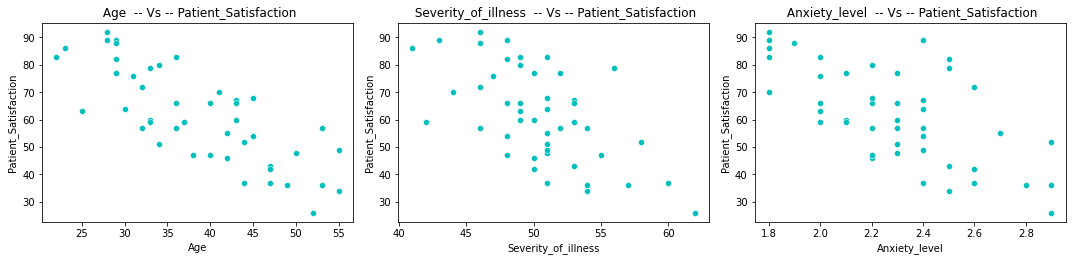

In [275]:
# Analysing the features with target
fig = plt.figure(figsize=(15,10))
i = 1
for feature in features:
    data = df.copy()
    fig.add_subplot(3,3,i)
    sns.scatterplot(x=data[feature],y=data[target],color = 'c')
    plt.title(f" {feature}  -- Vs -- {target}")
    i+=1
plt.tight_layout()    

***Observations:***
- All the **features are inversely proportional to the target** i.e; More the Age, Severity of illness and Anxiety level less is the patient satisfaction
- Age vs Patient satisfaction is comparitively less scattered whcih indicates that it is more linearly correlated with patient satisafaction


## Correlation Coefficient Function

In [276]:
# Correlation coefficient function
def Corr_coeff(x,y):     
    mean_x, mean_y = 0,0 
    # Calculating the mean for x and y variables
    for i , j in zip (x,y):
        mean_x += i
        mean_y += j
    mean_x /= x.count()
    mean_y /= y.count()
    
    num , den_x ,den_y = 0 , 0 , 0    
    for i,j in zip(x,y):
        num += (i - mean_x) * (j - mean_y)
        den_x += (i - mean_x)**2
        den_y += (j- mean_y)**2
    return num / (den_x**(1/2) * den_y**(1/2))

In [277]:
# Getting the Correaltion Coefficient with respect to the Target:
corr_series = {}
df_cor = pd.DataFrame()

for feature in features:
    data = df.copy()
    corr_series[feature] = [Corr_coeff(data[target], data[feature])]
    df_cor = pd.concat([df_cor , pd.DataFrame(corr_series,columns= [feature],index = [target])],axis=1)

df_cor = df_cor.T.sort_values(ascending = True , by = target )
df_cor.style.background_gradient(cmap = 'Blues')


,Patient_Satisfaction
Age,-0.786756
Anxiety_level,-0.644591
Severity_of_illness,-0.602942


**Observations:**
- As we have seen from the scatterplots that out of the features, Age is more correlated with the Target Which is again seen   from the Coorealtion coefficients
- The Negative sign on the correlation coefficient reflects the inverse corelation between the feature and target i.e; If the Age is more the Patient Satisfaction is tend to be less


### Visualising the Correlation coefficient using Heat Map

<AxesSubplot:>

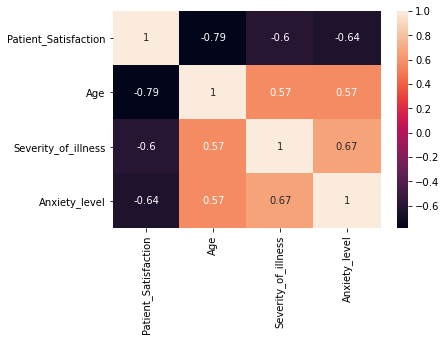

In [278]:
corelation = df.corr()
sns.heatmap(corelation,xticklabels = corelation.columns, yticklabels = corelation.columns, annot = True )

### Sub-Question 2 : 

Divide this data into K=10 folds of training and testing sets. Using your own implementations
of batch, stochastic and mini-batch gradient descent,fit a linear regression model using the
training data. Generate plots of the training loss for each iteration and implementation.
Experiment with different values for the learning rate and mini-batch size. Discuss how
you selected the optimal values for the learning rate and mini-batch size. Display the final
regression coeffcients for each implementation.

### Answer :

- Implemeted the fuctions for batch, stochastic and mini-batch gradient descent.
- Genreated the plots of tarning loss for each iteration and implementation.
- Tried various values for learning rate and mini batch size
- By comparing the cost and the mean square error, figured out the optimal values for learning rate and mini batch size
- Final regression coefficients for each of the implementations are printed







In [279]:
# Features and Target
X = df.drop([target], axis = 1)
y = df[target]

#### Scaling the Data Using Min-Max Scaling

In [280]:
# Using Min- Max scaling to Scale the data  
min_max_x = preprocessing.MinMaxScaler()
min_max_y = preprocessing.MinMaxScaler()
def min_max_scaling(X,y):    
    scaled_X = min_max_x.fit_transform(X)
    scaled_y = min_max_y.fit_transform(y)
    scaled_y = scaled_y.reshape(y.shape[0],)
    return scaled_X, scaled_y

In [281]:
# Initialising the weights to 1 and bias to 0
def get_init_weight_bias(X,y):
    n_rows,n_features = X.shape[0],X.shape[1]
    bias = 0
    weights = np.ones(shape=(n_features))
    return bias, weights

## Function for Batch Gradient Descent

In [282]:
# Function for Batch Gradient Descent
def batch_gradient_descent(X, y, epochs, lr):
    n_rows = X.shape[0]
    bias, weights = get_init_weight_bias(X, y)
    cost_list = []
    epoch_list = []
    for i in range(epochs):        
        y_pred = np.dot(weights, X.T) + bias        
        derv_weights = -(2/n_rows)*(X.T.dot(y-y_pred))
        derv_bias = -(2/n_rows)*np.sum(y-y_pred)        
        weights = weights - lr * derv_weights
        bias = bias - lr * derv_bias
        # Mean Square Error
        cost = np.mean(np.square(y-y_pred))
        cost_list.append(cost)
        epoch_list.append(i)
    return weights,bias,cost,cost_list,epoch_list

## Fucntion for Stochastic Gradient Descent

In [283]:
# Function for Stochastic Gradient Descent
def stochastic_gradient_descent(X, y, epochs, lr ):
 
    n_rows = X.shape[0]
    bias, weights = get_init_weight_bias(X, y)
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):
        # random index
        rand_i = random.randint(0,n_rows-1) 
        s_x = X[rand_i]
        s_y = y[rand_i]
        
        y_pred = np.dot(weights, s_x.T) + bias
    
        derv_weights = -(2/n_rows)*(s_x.T.dot(s_y-y_pred))
        derv_bias = -(2/n_rows)*(s_y-y_pred)
        
        weights = weights - lr * derv_weights
        bias = bias - lr * derv_bias
        
        cost = np.square(s_y-y_pred)
        
        cost_list.append(cost)
        epoch_list.append(i)  
            
    return weights, bias, cost, cost_list, epoch_list


## Fucntion for Mini Batch Gradient Descent

In [284]:
# Function for Mini Batch Gradient Descent
def mini_batch_gradient_descent(X, y, epochs, batch_size , lr):    
    n_rows = X.shape[0]
    bias, weights = get_init_weight_bias(X, y)
    
    # In this case mini batch becomes same as batch gradient descent
    if batch_size > n_rows: 
        batch_size = n_rows
        
    cost_list = []
    epoch_list = []
    
    n_batches = int(n_rows/batch_size)
    
    for i in range(epochs):    
        rand_i = np.random.permutation(n_rows)
        temp_x = X[rand_i]
        temp_y = y[rand_i]
        
        for j in range(0,n_rows,batch_size):
            new_x = temp_x[j:j+batch_size]
            new_y = temp_y[j:j+batch_size]
            y_pred = np.dot(weights, new_x.T) + bias
            
            derv_weights = -(2/len(new_x))*(new_x.T.dot(new_y-y_pred))
            derv_bias = -(2/len(new_x))*np.sum(new_y-y_pred)
            
            weights = weights - lr * derv_weights
            bias = bias - lr * derv_bias
            
            cost = np.mean(np.square(new_y-y_pred))
            cost_list.append(cost)
            epoch_list.append(i)
        
    return weights, bias, cost, cost_list, epoch_list


In [295]:
# Function for Predicting using the Test data
def predict(Age,Severity_of_illness,Anxiety_level,w,b):
    scaled_X = min_max_x.transform([[Age, Severity_of_illness,Anxiety_level]])[0]
    
    scaled_target = w[0] * scaled_X[0] + w[1] * scaled_X[1] + w[2] * scaled_X[2] + b
    
    # Inverse transform of scaled value to get original value
    return min_max_y.inverse_transform([[scaled_target]])[0][0]

In [296]:
# Calculate mean squared error
def mean_sq_err(actual, pred):
    e_sum = 0.0
    for j in range(len(actual)):
        e_pred = pred[j] - actual[j]
        e_sum += (e_pred ** 2)
        mean_sq_error = e_sum / float(len(actual))
    return mean_sq_error

### Analysing Learning Rates and BatchSize

In [297]:
def analysing_learning_rates(learning_rate ,epoch,batch_size):
    fold = 1
    list_cost_folds = [[],[],[]]
    list_epoch_folds = [[],[],[]]
    Mean_square_err_folds = [[],[],[]]

    # Implementing KFold for 10 folds
    kf = KFold(n_splits=10)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        y_train = y_train.values.reshape(y_train.count(),1)
        # Scaling the Train data
        scaled_X, scaled_y = min_max_scaling(X_train,y_train)    
    
        # Batch Gradient Descent
        w_bgd, b_bgd, cost_bgd, cost_list, epoch_list = batch_gradient_descent(scaled_X,scaled_y, epoch[0] ,learning_rate[0])
        list_cost_folds[0].append(cost_bgd)
    
        # Stochastic Gradient Descent  
        w_sgd, b_sgd, cost_sgd, cost_list, epoch_list = stochastic_gradient_descent(scaled_X,scaled_y,epoch[1] ,learning_rate[1])
        list_cost_folds[1].append(cost_sgd)
        
        # Mini Batch Gradient Descent    
        w_mbgd, b_mbgd, cost_mbgd, cost_list, epoch_list = mini_batch_gradient_descent(scaled_X,scaled_y,epoch[2],batch_size,learning_rate[2])    
        list_cost_folds[2].append(cost_mbgd)

    
        y_pred = [[],[],[]]
        # Calculating the mean square errors for the 3 gradient descents
        for t in X_test.T:
            y_hat = predict(X_test.T[t][0],X_test.T[t][1],X_test.T[t][2],w_bgd,b_bgd)
            y_pred[0].append(y_hat)
            y_hat = predict(X_test.T[t][0],X_test.T[t][1],X_test.T[t][2],w_sgd,b_sgd)
            y_pred[1].append(y_hat)
            y_hat = predict(X_test.T[t][0],X_test.T[t][1],X_test.T[t][2],w_mbgd,b_mbgd)
            y_pred[2].append(y_hat)
        
        
        Mean_square_err_folds[0].append(mean_sq_err(y_test.values, y_pred[0]))
        Mean_square_err_folds[1].append(mean_sq_err(y_test.values, y_pred[1]))
        Mean_square_err_folds[2].append(mean_sq_err(y_test.values, y_pred[2]))
    
    return list_cost_folds,Mean_square_err_folds  
   
  

#### Tried different values of learning rate and figured out optimal values. Out of those i have listed dow a few values which i have tried :

In [309]:
# Trying Different Learning rates and Batch sizes
lrs = [[],[],[]]
eps = [[],[],[]]
bszs = [0,0,0]
# Instance 1
lrs[0] = [0.05,0.07,0.03]
eps[0] = [800,10000,1100]
bszs[0] = 10
# Instance 2
lrs[1] = [0.1,0.1,0.01]
eps[1] = [1000,8000,1000]
bszs[1] = 10
# Instance 3
lrs[2] = [0.05,0.07,0.03]
eps[2] = [800,10000,1100]
bszs[2] = 15

In [310]:
for e,(lr,ep,bsz) in enumerate(zip(lrs,eps,bszs)):
    list_cf,list_mse = analysing_learning_rates(lr,ep,bsz)
    mse = pd.DataFrame()
    mse['MSE of BGD'] = list_mse[0]
    mse['Cost of BGD'] = list_cf[0]
    mse['MSE of SGD'] = list_mse[1]
    mse['Cost of SGD'] = list_cf[1]
    mse['MSE of MBGD'] = list_mse[2]    
    mse['Cost of MBGD'] = list_cf[2]
    display(f'For Learning rate and Batch size of Instance - {e+1}')
    display(mse.style.background_gradient(cmap = 'YlGn'))

'For Learning rate and Batch size of Instance - 1'

,MSE of BGD,Cost of BGD,MSE of SGD,Cost of SGD,MSE of MBGD,Cost of MBGD
0,29.024238,0.023212,45.693997,0.001112,38.916372,0.036388
1,59.491592,0.029015,99.084992,0.067146,52.136211,0.010124
2,230.664840,0.017892,239.635808,0.002024,219.066177,0.030127
3,114.163120,0.020783,116.577112,0.033501,109.387467,0.031988
4,39.130892,0.022912,35.100594,0.109005,44.809977,0.000005
5,129.246196,0.020855,114.469713,0.011995,134.729178,0.002198
6,161.592586,0.019771,118.234605,0.006504,193.607411,0.028271
7,98.060470,0.021640,144.952971,0.131595,82.781222,0.028221
8,68.849162,0.022064,88.457897,0.000945,60.809662,0.003827
9,128.978118,0.022541,150.670248,0.000638,136.098956,0.032092


'For Learning rate and Batch size of Instance - 2'

,MSE of BGD,Cost of BGD,MSE of SGD,Cost of SGD,MSE of MBGD,Cost of MBGD
0,30.045582,0.022997,38.484133,0.002970,29.008171,0.001565
1,58.135068,0.028966,97.157003,0.020891,63.361523,0.104674
2,224.508009,0.017703,237.858765,0.052487,227.176679,0.000184
3,116.239187,0.020648,120.285909,0.032616,114.876866,0.001326
4,40.753733,0.022804,29.888957,0.006209,46.994121,0.014576
5,124.401479,0.020731,112.421148,0.012448,130.847048,0.000763
6,189.212491,0.019435,125.999629,0.001812,174.627051,0.017209
7,87.215955,0.021485,133.571086,0.026399,88.748358,0.021510
8,62.772263,0.021915,83.866284,0.019706,67.154860,0.009064
9,136.419211,0.022384,137.098729,0.022235,130.903918,0.020222


'For Learning rate and Batch size of Instance - 3'

,MSE of BGD,Cost of BGD,MSE of SGD,Cost of SGD,MSE of MBGD,Cost of MBGD
0,29.024238,0.023212,52.225823,0.011191,29.643406,0.026869
1,59.491592,0.029015,107.495056,0.012442,56.372106,0.027080
2,230.664840,0.017892,236.568392,0.003060,225.154002,0.015321
3,114.163120,0.020783,108.900373,0.001499,114.405059,0.017365
4,39.130892,0.022912,40.896663,0.005323,40.177268,0.037283
5,129.246196,0.020855,118.447775,0.004933,122.280699,0.028963
6,161.592586,0.019771,120.203803,0.007391,190.055295,0.023138
7,98.060470,0.021640,145.670614,0.017986,85.912049,0.018202
8,68.849162,0.022064,95.206001,0.055474,62.343180,0.023397
9,128.978118,0.022541,154.577715,0.012977,136.260309,0.021074


### Implementing the K Fold and calling the Gradient Descent Functions

In [306]:
fold = 1
list_cost_folds = [[],[],[]]
list_epoch_folds = [[],[],[]]
Mean_sq_err_folds = [[],[],[]]


print('*'*105)
print("#"*30, "Regression Coefficients for each Implementaion", '#'*27 )

# Implementing KFold for 10 folds
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    y_train = y_train.values.reshape(y_train.count(),1)
    # Scaling the Train data
    scaled_X, scaled_y = min_max_scaling(X_train,y_train)
    
    
    print('*'*105)
    print(' '*40, "*****  For K-fold - ", fold , '******')
    fold += 1
    print('*'*105)
    
    
    # Batch Gradient Descent
        
    learning_rate = 0.05
    epoch = 800
    w_bgd, b_bgd, cost_bgd, cost_list, epoch_list = batch_gradient_descent(scaled_X,scaled_y, epoch ,learning_rate)
    
    print(f"The regression Coefficients of Batch Gradient Descent are: ")
    print(f"Weights = {w_bgd} , Bias = {b_bgd} , Cost = {cost_bgd} ")    
    
    list_cost_folds[0].append(cost_list)
    list_epoch_folds[0].append(epoch_list)
    
    # Stochastic Gradient Descent
    
    learning_rate = 0.07
    epoch = 10000   
    w_sgd, b_sgd, cost_sgd, cost_list, epoch_list = stochastic_gradient_descent(scaled_X,scaled_y,epoch ,learning_rate)
    
    list_cost_folds[1].append(cost_list)
    list_epoch_folds[1].append(epoch_list)
    
    print('~'*105)
    print(f"The regression Coefficients of Stochastic Gradient Descent are: ")
    print(f"Weights = {w_sgd} , Bias = {b_sgd} , Cost = {cost_sgd} ")
    
    # Mini Batch Gradient Descent
    
    epochs = 1100
    batch_size = 10
    lr = 0.03
    w_mbgd, b_mbgd, cost_mbgd, cost_list, epoch_list = mini_batch_gradient_descent(scaled_X,scaled_y,epochs,batch_size ,lr)    
    
    list_cost_folds[2].append(cost_list)
    list_epoch_folds[2].append(epoch_list)
    
    print('~'*105)
    print(f"The regression Coefficients of Mini Batch Gradient Descent : ")
    print(f"Weights = {w_mbgd} , Bias = {b_mbgd} , Cost = {cost_mbgd} ")
    
    y_pred = [[],[],[]]
# Calculating the mean square errors for the 3 gradient descents
    for t in X_test.T:
        y_hat = predict(X_test.T[t][0],X_test.T[t][1],X_test.T[t][2],w_bgd,b_bgd)
        y_pred[0].append(y_hat)
        y_hat = predict(X_test.T[t][0],X_test.T[t][1],X_test.T[t][2],w_sgd,b_sgd)
        y_pred[1].append(y_hat)
        y_hat = predict(X_test.T[t][0],X_test.T[t][1],X_test.T[t][2],w_mbgd,b_mbgd)
        y_pred[2].append(y_hat)
        
        
    Mean_sq_err_folds[0].append(mean_sq_err(y_test.values, y_pred[0]))
    Mean_sq_err_folds[1].append(mean_sq_err(y_test.values, y_pred[1]))
    Mean_sq_err_folds[2].append(mean_sq_err(y_test.values, y_pred[2]))
   
  

*********************************************************************************************************
############################## Regression Coefficients for each Implementaion ###########################
*********************************************************************************************************
                                         *****  For K-fold -  1 ******
*********************************************************************************************************
The regression Coefficients of Batch Gradient Descent are: 
Weights = [-0.58796201 -0.0466756  -0.2478266 ] , Bias = 0.9583851935434647 , Cost = 0.023211566025094197 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The regression Coefficients of Stochastic Gradient Descent are: 
Weights = [-0.49263204  0.10083446 -0.26656539] , Bias = 0.8478916650335989 , Cost = 0.0477286181932612 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

### Plotting the Training Loss for each Iteration and Implementation

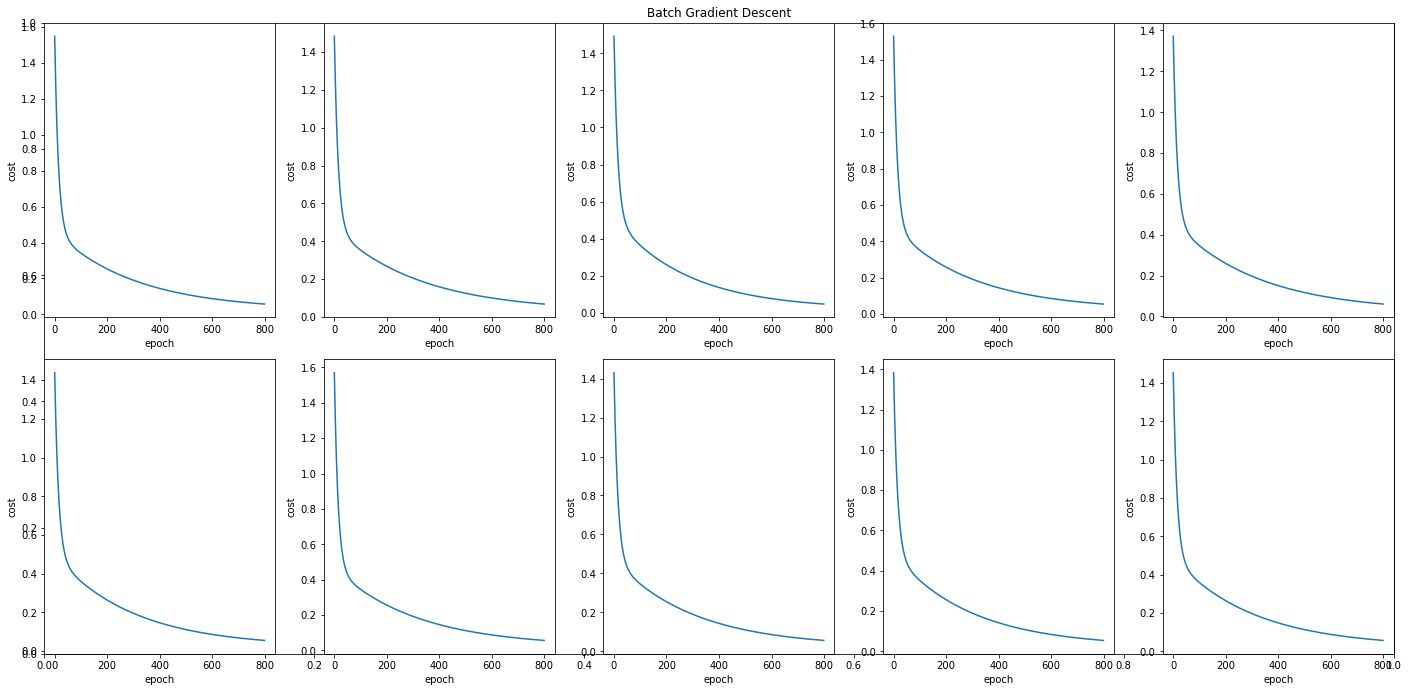

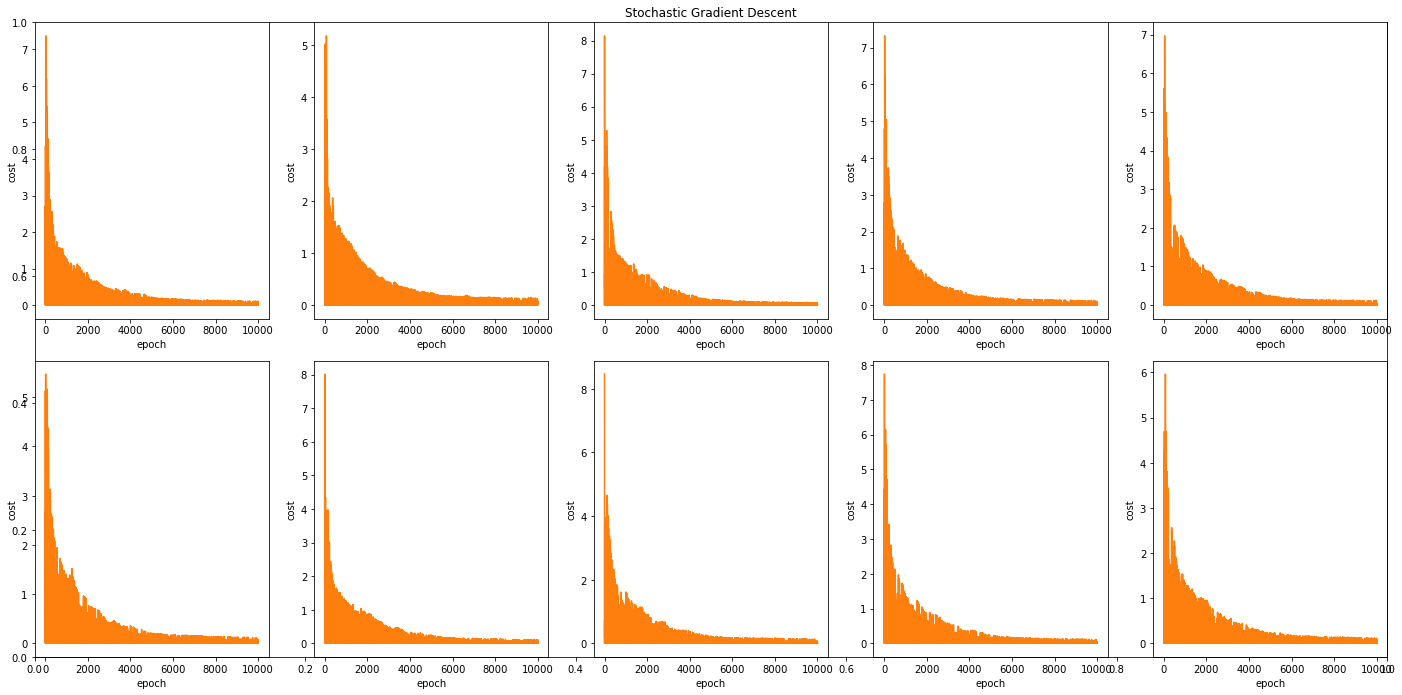

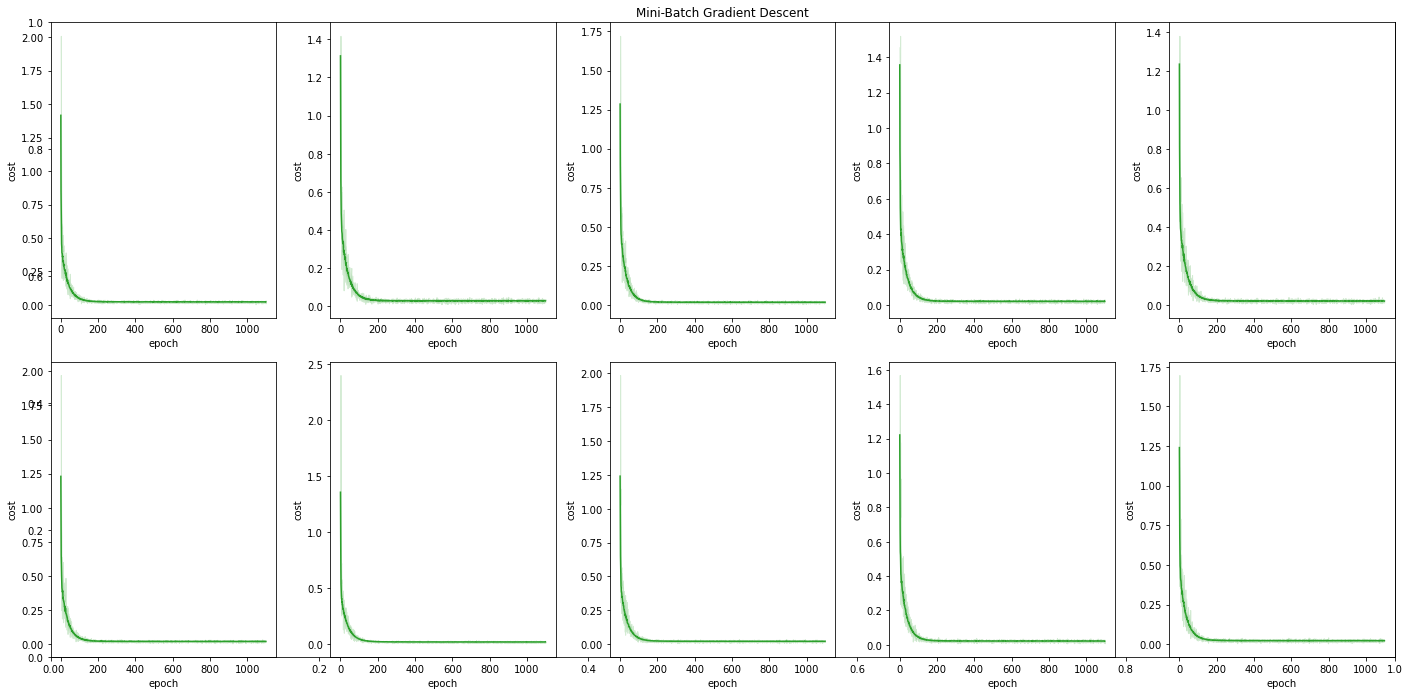

In [291]:
titles = ["Batch Gradient Descent","Stochastic Gradient Descent","Mini-Batch Gradient Descent"]
palette = itertools.cycle(sns.color_palette())
for cost_of_descent,epoch_of_descent,title in zip(list_cost_folds,list_epoch_folds,titles):
    fig = plt.figure(figsize=(20,10))    
    c = next(palette)
    plt.title(title)    
    i = 1
    for cost,epoch in zip(cost_of_descent,epoch_of_descent):
        fig.add_subplot(2,5,i)
        sns.lineplot(x= epoch, y=cost, color = c)
        plt.xlabel("epoch")
        plt.ylabel("cost")
        i+=1
    plt.tight_layout()

In [307]:
mean_sq_err_df = pd.DataFrame()
mean_sq_err_df['MSE of BGD'] = Mean_sq_err_folds[0]
mean_sq_err_df['MSE of SGD'] = Mean_sq_err_folds[1]
mean_sq_err_df['MSE of MBGD'] = Mean_sq_err_folds[2]    
display(mean_sq_err_df.style.background_gradient(cmap = 'YlGn'))

,MSE of BGD,MSE of SGD,MSE of MBGD
0,29.024238,49.176069,30.255657
1,59.491592,101.568683,34.620176
2,230.664840,236.533133,227.160001
3,114.163120,112.304736,110.614585
4,39.130892,34.511114,38.674192
5,129.246196,123.356162,120.642133
6,161.592586,117.716746,192.870843
7,98.060470,136.341881,84.886337
8,68.849162,99.744397,68.876998
9,128.978118,149.607176,138.586640


### Sub-Question   3 : 

Once trained, use the testing data and mean-square error to evaluate performance. Which
approach performed best? Why?

### Answer :
  - We have tried different learning rates and different batch sizes and reduced the training cost. For each of the Gradient descents we have got different learning rates , epochs and batch sizes.
  - For the different Gradient Descents:
    - Batch Gradient Descent : The learning rate is **0.05** and epochs = **800** which results in minimal costs and comparitivley less mean square error for all folds
    - Stochastic Gradient Descent : The learning rate is **0.07** and epochs = **10000** which results in minimal costs and comparitivley less mean square error for all folds. AS we take one row of data , which results in noise in the graphs.
    - Mini Batch Gradient Descent : The learning rate is **0.03** and epochs = **1100** and Batch Size = **10** which results in minimal costs and comparitivley less mean square error for all folds. 
  - As we are spliting the train data and test data , few folds may not perform better than the others. 


**When comparing the mean square errors of the 3 Gradient Descents and the noice in the graphs we can come to a conclusion that Batch Gradient descent is preferred in this scenario**